In [1]:
!pwd

/notebooks/paddy


In [4]:
def do_setup():
    # How to download competition data to temp folder(data) 
    # unzip it there, then symlink it like its a subdir
    # NOTE: make sure kaggle.json is in /root/.kaggle/

    #remove original symlink from this directory
    !rm ./data

    #create temp holder
    !mkdir /root/data

    #symlink it
    !ln -s /root/data ./data

    #download competition data to temp data folder
    !cd ./data;kaggle competitions download -c paddy-disease-classification

    #unzip it, -q is silent
    !cd ./data;unzip -q paddy-disease-classification.zip

    #setup dotfiles
    !wget "https://raw.githubusercontent.com/CNUClasses/dotfiles/master/setup.sh";chmod 766 setup.sh;source ./setup.sh  
    
import os
if(not os.path.exists('./data/train_images')):
   do_setup()  

In [5]:
import pandas as pd
df =pd.read_csv('./data/train.csv')
df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [6]:
try: from path import Path
except ModuleNotFoundError:
    !pip install path
try: import timm
except ModuleNotFoundError:
    !pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 46.6 MB/s eta 0:00:00


In [7]:
from fastai.vision.all import *
set_seed(42)

path =Path('./data/')

In [8]:
path.ls()

(#5) [Path('data/train_images'),Path('data/train.csv'),Path('data/sample_submission.csv'),Path('data/paddy-disease-classification.zip'),Path('data/test_images')]

In [9]:
files=get_image_files(path/'train_images')
files

(#10407) [Path('data/train_images/bacterial_leaf_streak/100081.jpg'),Path('data/train_images/bacterial_leaf_streak/104135.jpg'),Path('data/train_images/bacterial_leaf_streak/108249.jpg'),Path('data/train_images/bacterial_leaf_streak/100235.jpg'),Path('data/train_images/bacterial_leaf_streak/105265.jpg'),Path('data/train_images/bacterial_leaf_streak/109925.jpg'),Path('data/train_images/bacterial_leaf_streak/106054.jpg'),Path('data/train_images/bacterial_leaf_streak/103307.jpg'),Path('data/train_images/bacterial_leaf_streak/106974.jpg'),Path('data/train_images/bacterial_leaf_streak/101151.jpg')...]

(480, 640)


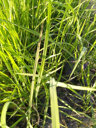

In [10]:
img=PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [11]:
from fastcore.parallel import *
def f(o): return PILImage.create(o).size
sizes=parallel(f,files,n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

In [12]:
trnpath=path/'train_images'

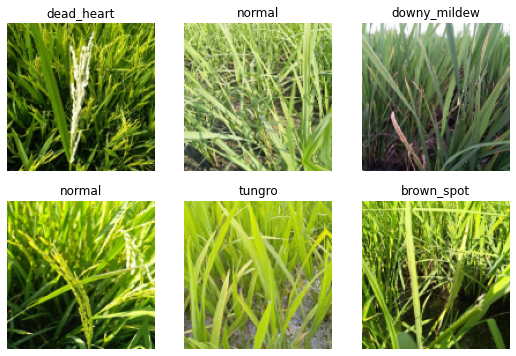

In [68]:
dls=ImageDataLoaders.from_folder(trnpath, valid_pct=0.2, seed=42,item_tfms=Resize(480, method='squish'),batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls.show_batch(max_n=6)

In [108]:
learn=vision_learner(dls,'resnet26d', metrics=error_rate,path='.')

SuggestedLRs(valley=0.0012022644514217973, slide=0.0063095735386013985)

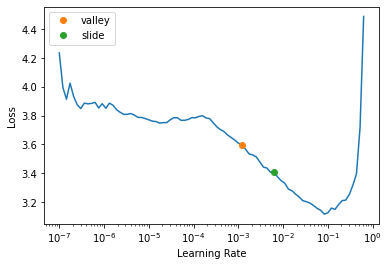

In [42]:
learn.lr_find(suggest_funcs=(valley,slide))

In [70]:
learn.fine_tune(3,0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.764551,1.200157,0.399327,00:23


epoch,train_loss,valid_loss,error_rate,time
0,1.102208,0.783489,0.243152,00:27
1,0.754522,0.458278,0.143681,00:27
2,0.572506,0.388354,0.121096,00:27


### Try multihead

In [101]:
#get the model thats part of learner
m=learn.model
# m

In [72]:
#gets the head of the model
h=m[1]
h

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

In [73]:
#subtract the last layer
ll=h[-1]
ll

Linear(in_features=512, out_features=10, bias=False)

In [74]:
llp=list(ll.parameters())[0]

In [75]:
#get rid of last linear layer in model
del(h[-1])
# m

In [107]:
# learn.model

## Multihead

In [117]:
dls=ImageDataLoaders.from_folder(trnpath, valid_pct=0.2, seed=42,item_tfms=Resize(480),batch_tfms=aug_transforms(size=224, min_scale=0.75))
learn=vision_learner(dls,'resnet26d', metrics=error_rate,path='.')

In [118]:
import torch.nn as nn
class DiseaseAndTypeClassifier(nn.Module):
    def __init__(self,m):
        #lets strip the last layer out of the head
        del m[1][-1]
        super(DiseaseAndTypeClassifier,self).__init__()
        self.l1=nn.Linear(in_features=512, out_features=10, bias=False)
        self.l2=nn.Linear(in_features=512, out_features=10, bias=False)
        self.m=m
        
    def forward(self,x):
        x=self.m(x)
        x1=self.l1(x)
        x2=self.l2(x)
        return x1,x2
      

In [119]:
dtc=DiseaseAndTypeClassifier(learn.model)
learn.model=dtc
res=learn.get_preds(dl=learn.dls.valid)

AttributeError: 'tuple' object has no attribute 'view'

In [98]:
#copy and deepcopy is causing problems below
# from copy import copy,deepcopy
# arch='resnet26d'
# dls=ImageDataLoaders.from_folder(trnpath, valid_pct=0.2, seed=42,item_tfms=Resize(480),batch_tfms=aug_transforms(size=224, min_scale=0.75))
# learn3=vision_learner(dls,arch,metrics=error_rate)
# learn2=deepcopy(learn3)

### Old notebook

In [ ]:
llp.shape

In [ ]:
path

In [ ]:
ss=pd.read_csv(path/'sample_submission.csv')

In [ ]:
ss

In [ ]:
tst_files=get_image_files(path/'test_images').sorted()

tst_dl=dls.test_dl(tst_files)

In [ ]:
probs, bb, idxs=learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

In [ ]:
dls.vocab

In [ ]:
d=dict(enumerate(dls.vocab))

In [ ]:
idxs_np=idxs.clone()

In [ ]:
idxs

In [ ]:
vals=pd.Series(data=idxs, name="idxs").map(d)
vals

In [ ]:
ss.label=vals

In [ ]:
ss

In [ ]:
ss.to_csv('subm.csv',index=False)

In [ ]:
!pwd

In [ ]:
from kaggle import api
comp = 'paddy-disease-classification'
api.competition_submit_cli('subm.csv', 'init', comp)